# Pulmonary Fibrosis Prediction - Hierarchical Regression Example

Dataset from: https://www.kaggle.com/competitions/osic-pulmonary-fibrosis-progression/data

Import necessary libraries:

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import gamma
import preliz as pz
import matplotlib as mpl
import pymc as pm
import bambi as bmb

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

## Load and Explore Data

In [3]:
data = pd.read_csv("pulmonary_fibrosis_train.csv")
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
data.shape

(1549, 7)

Number of patients:

In [5]:
len( data.Patient.unique() )

176

Number of measurements per patient:

In [6]:
data.groupby("Patient").size().value_counts().sort_index()

6       2
7       7
8      25
9     132
10     10
Name: count, dtype: int64

Age distribution:

<Axes: >

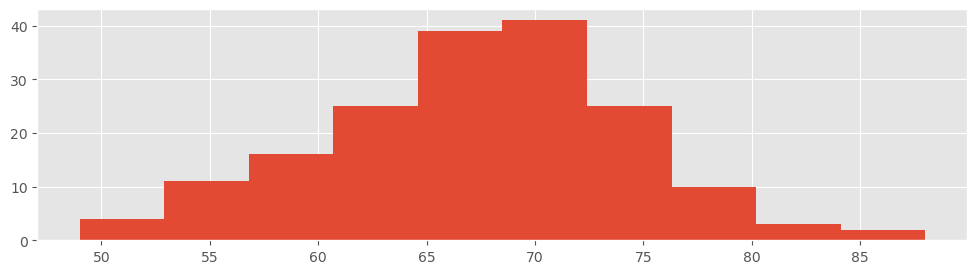

In [7]:
data.groupby("Patient").Age.first().hist()

Sex distribution:

In [8]:
data.groupby("Patient").Sex.first().value_counts()

Sex
Male      139
Female     37
Name: count, dtype: int64

Smokers:

In [9]:
data.groupby("Patient").SmokingStatus.first().value_counts()

SmokingStatus
Ex-smoker           118
Never smoked         49
Currently smokes      9
Name: count, dtype: int64

(smoking could be among causes for this disease..)

Plot a few patient forced vital capacity (FVC) evolutions with linear (frequentist) line fits:

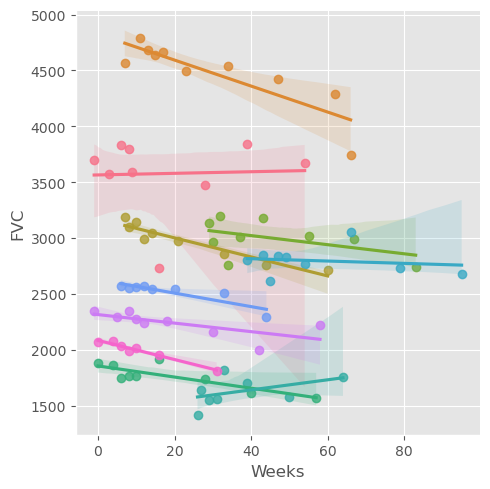

In [10]:
np.random.seed(1)
sample_patients = np.random.choice( data.Patient.unique(), 10 )
sns.lmplot( data=data[data.Patient.isin(sample_patients)], x="Weeks", y="FVC", hue="Patient", legend=False )

The starting capacities vary quite a bit (probably constitution), also slopes seem to vary by quite a bit.

## Hierarchical Regression with Bambi

In [11]:
hierarchical_model = bmb.Model("FVC ~ 1 + Weeks + (1 + Weeks | Patient)", data=data)
hierarchical_trace = hierarchical_model.fit( draws=3000, tune=3000 )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Weeks, 1|Patient_sigma, 1|Patient_offset, Weeks|Patient_sigma, Weeks|Patient_offset]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 78 seconds.
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


We have to be careful here. Check distribution of ESS and rhat via summary:

In [12]:
summary = pm.summary( hierarchical_trace )
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,136.590,2.821,131.256,141.771,0.025,0.026,12542.0,8934.0,1.0
Intercept,2807.118,62.272,2692.347,2923.773,3.209,1.539,376.0,866.0,1.0
Weeks,-4.276,0.443,-5.090,-3.439,0.006,0.004,5741.0,7694.0,1.0
1|Patient_sigma,830.714,45.132,747.950,916.270,1.525,0.679,871.0,2343.0,1.0
Weeks|Patient_sigma,5.092,0.366,4.413,5.785,0.005,0.003,6302.0,9130.0,1.0
...,...,...,...,...,...,...,...,...,...
Weeks|Patient[ID00419637202311204720264],1.703,2.367,-2.885,6.109,0.016,0.025,22479.0,8497.0,1.0
Weeks|Patient[ID00421637202311550012437],2.341,1.987,-1.314,6.078,0.015,0.019,18624.0,9123.0,1.0
Weeks|Patient[ID00422637202311677017371],-0.533,2.980,-6.255,4.880,0.018,0.032,27337.0,9195.0,1.0
Weeks|Patient[ID00423637202312137826377],-3.875,2.311,-8.086,0.497,0.015,0.023,23787.0,8938.0,1.0


There seem to be quite a lot of parameters in the model. General types of variables (see lecture):

In [13]:
hierarchical_trace.posterior.data_vars

Data variables:
    sigma                (chain, draw) float64 96kB 138.2 135.9 ... 136.5 135.9
    Intercept            (chain, draw) float64 96kB 2.852e+03 ... 2.851e+03
    Weeks                (chain, draw) float64 96kB -2.951 -3.51 ... -4.242
    1|Patient_sigma      (chain, draw) float64 96kB 776.0 768.1 ... 844.8 868.4
    Weeks|Patient_sigma  (chain, draw) float64 96kB 5.083 5.164 ... 5.414 5.731
    1|Patient            (chain, draw, Patient__factor_dim) float64 17MB -656...
    Weeks|Patient        (chain, draw, Patient__factor_dim) float64 17MB 0.64...

Distribution of rhat and ESS:

In [14]:
summary.r_hat.max()

np.float64(1.0)

In [15]:
summary.ess_bulk.min()

np.float64(376.0)

In [16]:
summary.ess_tail.min()

np.float64(866.0)

A few hundred for estimating the intercept does not seem problematic.

## Global Model (Disease Level)

What can we say in general about the progression of the pulmonary fibrosis disease?

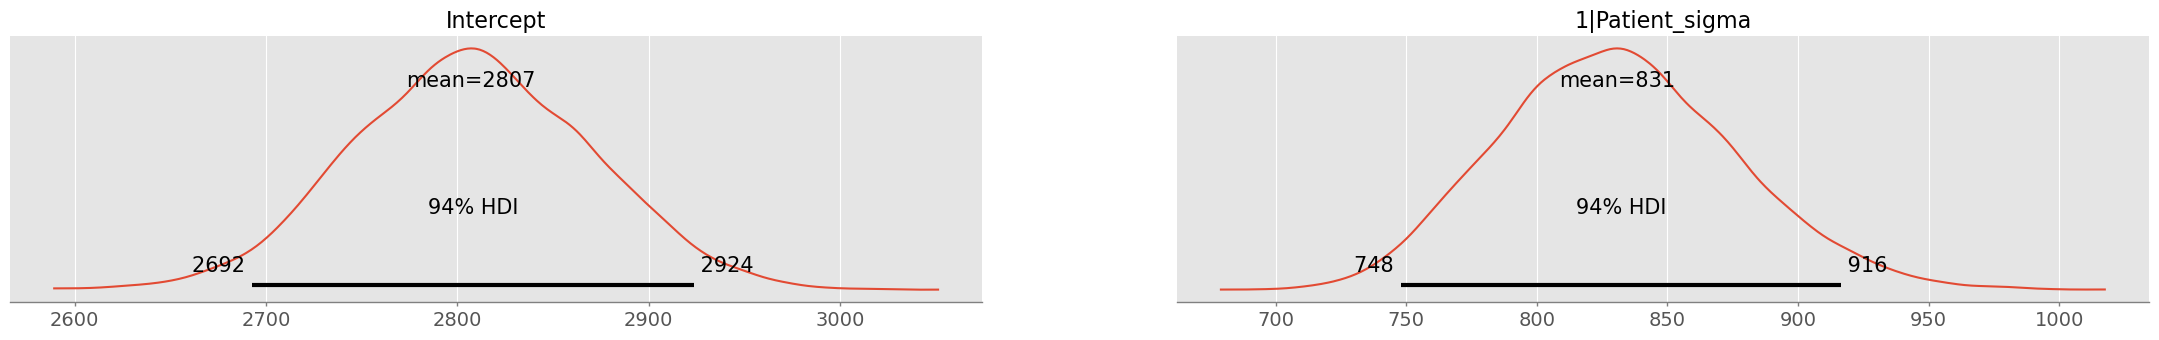

In [17]:
pm.plot_posterior( hierarchical_trace, var_names=["Intercept","1|Patient_sigma"] );

Intercepts vary by quite a bit. This is reasonable, because patients have different constitutions and seems to have nothing to do with disease evolution.

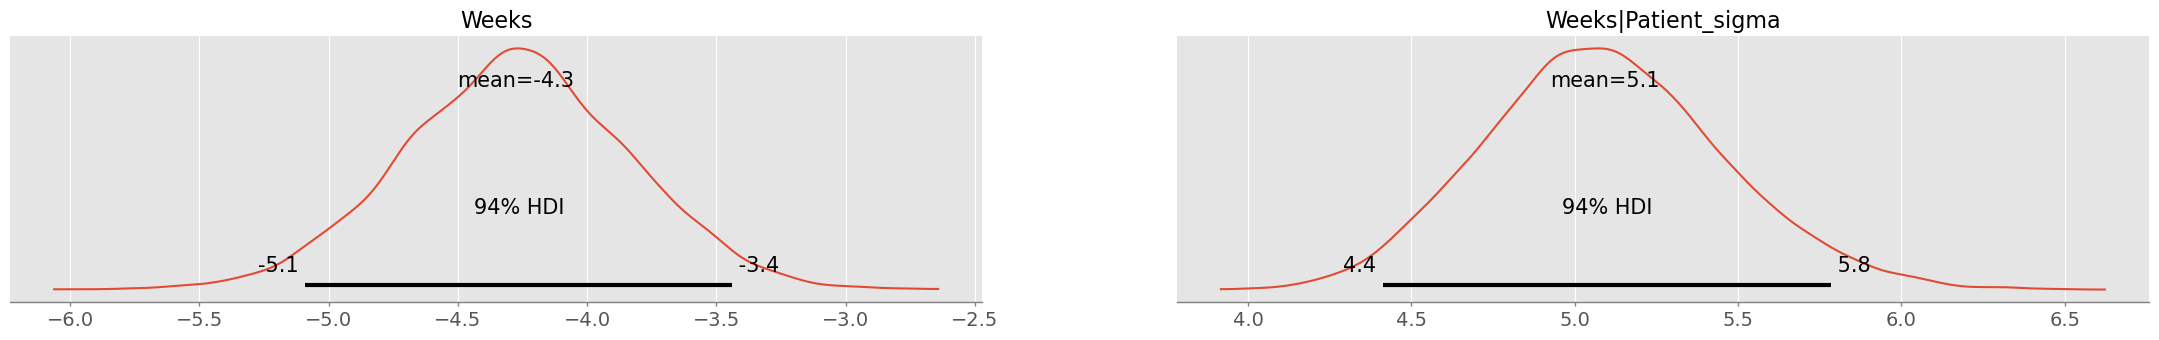

In [18]:
pm.plot_posterior( hierarchical_trace, var_names=["Weeks","Weeks|Patient_sigma"] );

Forced vital capacity decreases by 4.3ml on average per week.

## Patient-Level Models

Plot time evolution for individual patient with full predictive uncertainty:

/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/arviz/rcparams.py:368: FutureWarning: stats.hdi_prob is deprecated since 0.18.0, use stats.ci_prob instead
  warnings.warn(


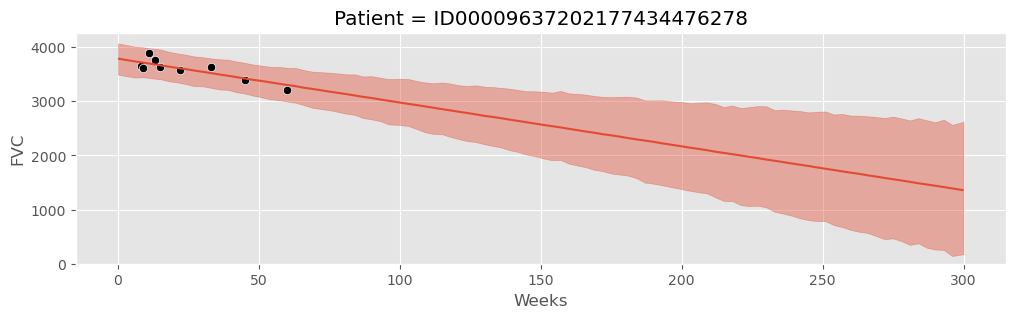

In [19]:
ax = plt.gca()
bmb.interpret.plot_predictions( 
    hierarchical_model, hierarchical_trace,
    conditional={"Weeks": np.linspace(0, 300, 100), "Patient": "ID00009637202177434476278"},
    subplot_kwargs={"main": "Weeks", "panel": "Patient"},
    pps=True, 
    legend=False,
    ax=ax
)
sns.scatterplot( x="Weeks", y="FVC", ax=ax, data=data[data.Patient=="ID00009637202177434476278"], color="black" )
ax.set_ylim(bottom=0);

Plot a random sample of patients:

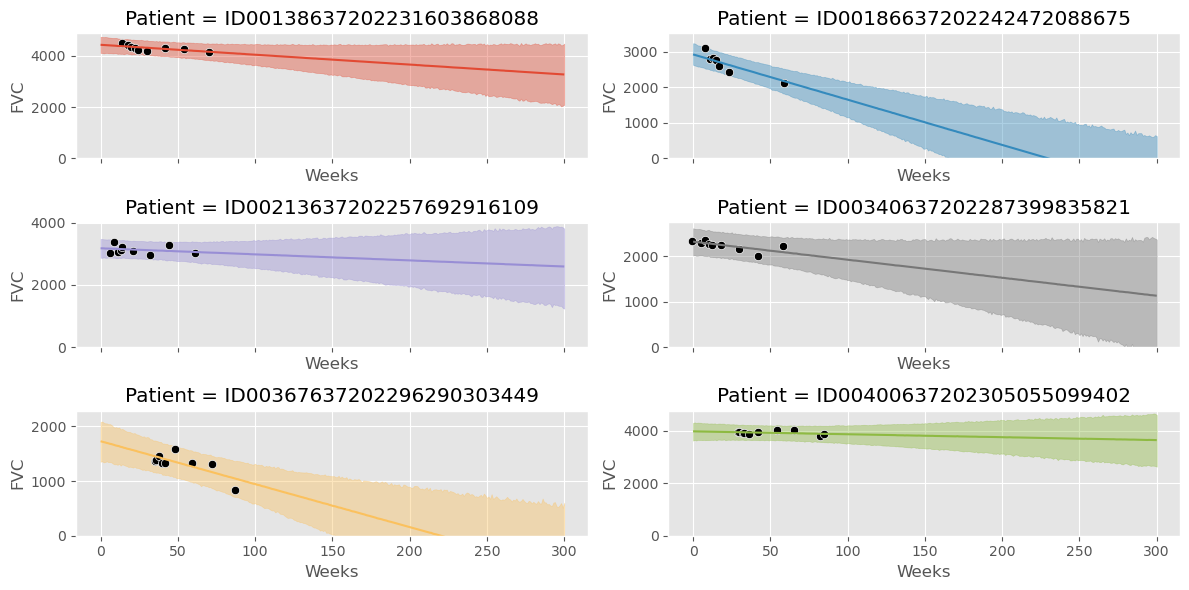

In [20]:
def plot_patients( patients, data, model, trace, ncols = 2, pps=True ):
    # create figure
    nrows = int(np.ceil(len(patients) / ncols))
    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols,
        figsize=(12, 2*nrows), sharex=True, sharey=False
    )

    # show lines with epistemic uncertainty
    fig, _ = bmb.interpret.plot_predictions( 
        model, trace,
        conditional={"Weeks": np.linspace(0, 300, 1000), "Patient": patients},
        subplot_kwargs={"main": "Weeks", "panel": "Patient"},
        prob=0.95,
        pps=pps,
        legend=False,
        fig_kwargs={"figsize": (12, 8), "sharex": True, "sharey": False},
        ax = axes
    )

    # if only one row
    if len(axes.shape) == 1:
        axes = axes.reshape(1,-1)

    for i, p in enumerate( patients ):
        ax = axes[int(i/ncols),i%ncols]
        sns.scatterplot( x="Weeks", y="FVC", ax=ax, data=data[data.Patient==p], color="black" )
        ax.set_ylim(bottom=0)

    plt.tight_layout()

patients = data.Patient.unique()
np.random.seed(41)
patient_sample = sorted( np.random.choice( patients, size=6 ) )
plot_patients( patient_sample, data, hierarchical_model, hierarchical_trace, pps=True )

### Using PyMC instead of Bambi / Demonstration of Shrinkage

To demonstrate shrinkage, we retrain our models in PyMC for better control over what we want to compare:

In [21]:
patients = pd.Index(sorted(data["Patient"].unique()), name="Patient")
patient_idx = pd.Categorical(data["Patient"], categories=patients).codes
y = data["FVC"].to_numpy()

with pm.Model(coords={"Patient": patients, "obs": np.arange(len(y))}) as hierarchical_model2:
    beta0 = pm.Normal("beta0", mu=y.mean(), sigma=y.mean()*5)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    sigma0 = pm.HalfNormal("sigma0", y.std())
    sigma1 = pm.HalfNormal("sigma1", 10)
    beta0j = pm.Normal("beta0j", mu=beta0, sigma=sigma0, dims="Patient")
    beta1j = pm.Normal("beta1j", mu=beta1, sigma=sigma1, dims="Patient")
    sigma_y = pm.HalfNormal("sigma_y", sigma=y.std())
    pm.Normal("y_obs", mu=beta0j[patient_idx] + beta1j[patient_idx] * data.Weeks, sigma=sigma_y, observed=y, dims="obs")
    hierarchical_trace2 = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma0, sigma1, beta0j, beta1j, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.


Also train individual model:

In [22]:
with pm.Model(coords={"Patient": patients, "obs": np.arange(len(y))}) as individual_models2:
    beta0j = pm.Normal("beta0j", mu=y.mean(), sigma=y.mean()*5, dims="Patient")
    beta1j = pm.Normal("beta1j", mu=0, sigma=10, dims="Patient")
    sigma_y = pm.HalfNormal("sigma_y", sigma=y.mean()*5)
    pm.Normal("y_obs", mu=beta0j[patient_idx] + beta1j[patient_idx] * data.Weeks, sigma=sigma_y, observed=y, dims="obs")
    individual_trace2 = pm.sample(1000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0j, beta1j, sigma_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.


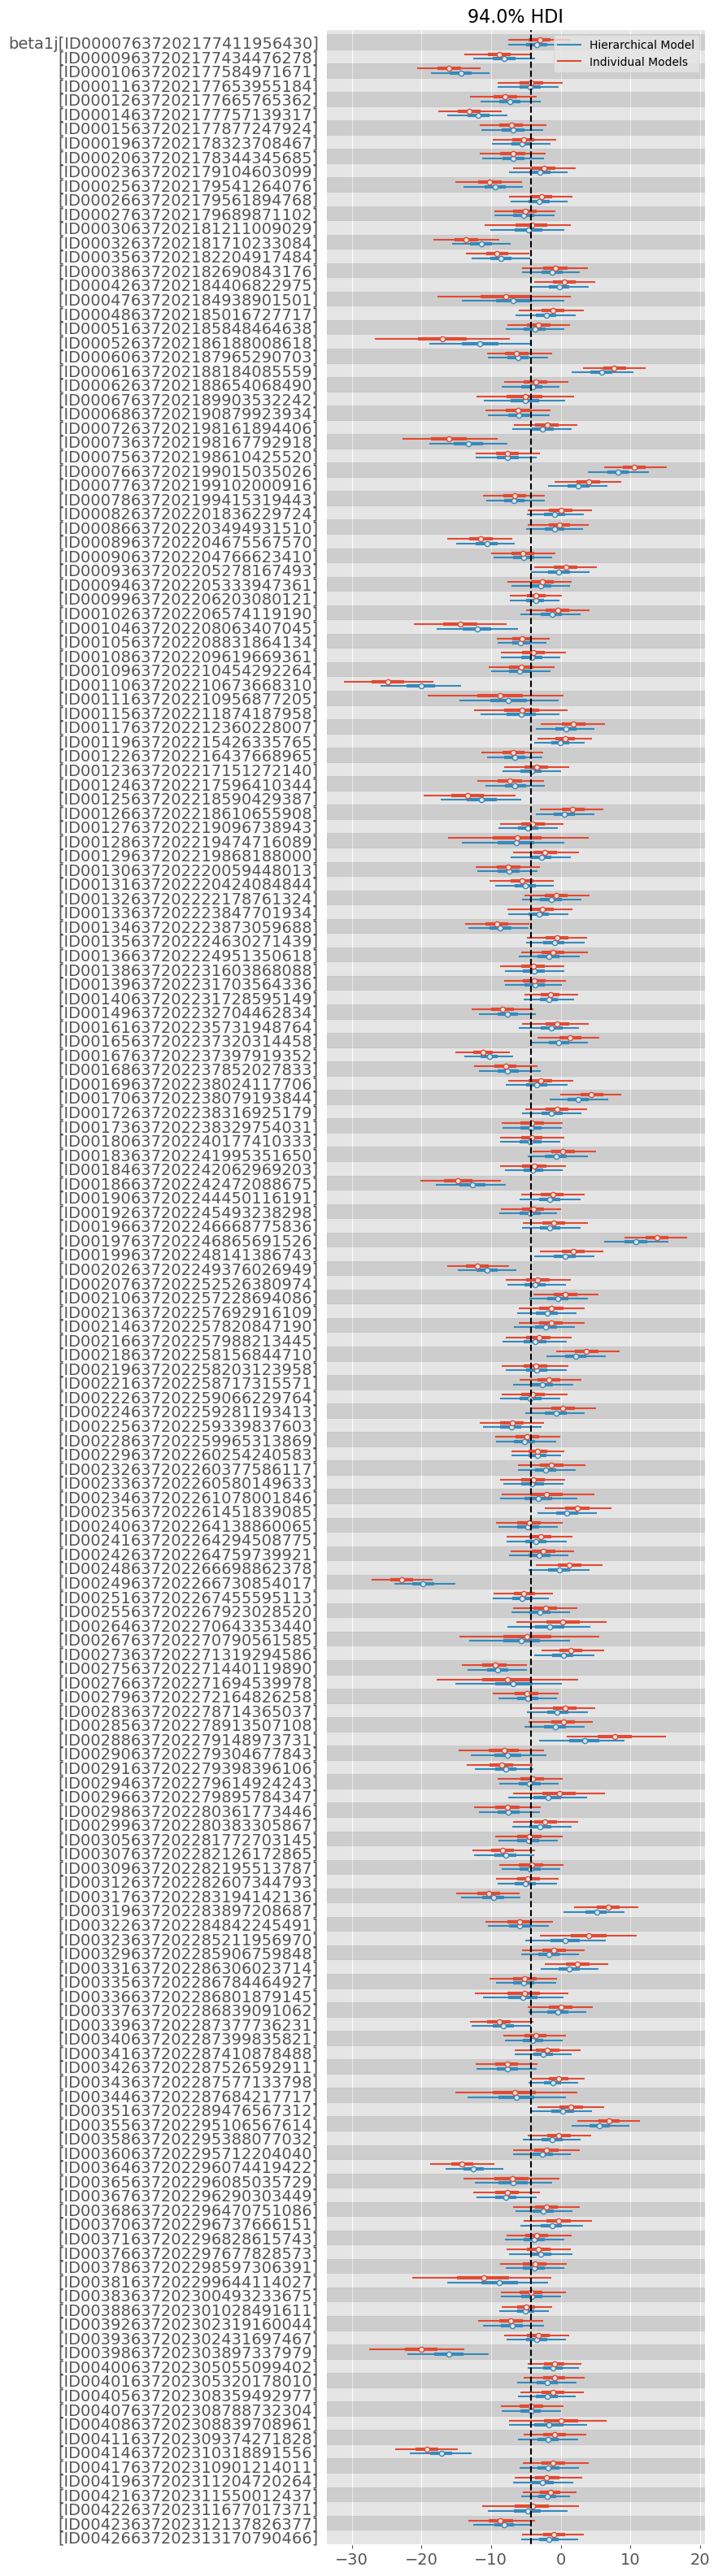

In [23]:
pm.plot_forest( 
    [individual_trace2, hierarchical_trace2], 
    model_names = ["Individual Models", "Hierarchical Model"],
    combined=True, 
    var_names="beta1j",
)
plt.axvline( hierarchical_trace2.posterior.beta1.mean(), c="black", ls="--" )

Shrinkage towards the global mean is evident: The larger the uncertainty and the greater the distance from the global mean, the more shrinkage.

## Making Predictions

For an existing patient:

In [24]:
data[data.Patient=="ID00009637202177434476278"]

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
9,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker
10,ID00009637202177434476278,9,3610,84.117812,69,Male,Ex-smoker
11,ID00009637202177434476278,11,3895,90.758691,69,Male,Ex-smoker
12,ID00009637202177434476278,13,3759,87.589710,69,Male,Ex-smoker
13,ID00009637202177434476278,15,3639,84.793550,69,Male,Ex-smoker
14,ID00009637202177434476278,22,3578,83.372169,69,Male,Ex-smoker
15,ID00009637202177434476278,33,3625,84.467332,69,Male,Ex-smoker
16,ID00009637202177434476278,45,3390,78.991518,69,Male,Ex-smoker
17,ID00009637202177434476278,60,3214,74.890484,69,Male,Ex-smoker


What will their FVC be after 2 years (106 weeks)?

<Axes: title={'center': 'FVC\n0'}>

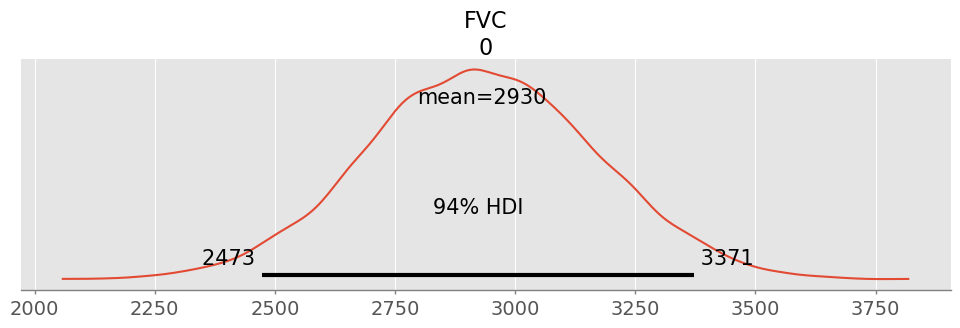

In [25]:
new_data = pd.DataFrame({"Patient": ["ID00009637202177434476278"], "Weeks": [106]})
hierarchical_model.predict( hierarchical_trace, kind="response", data=new_data )
pm.plot_posterior( hierarchical_trace, group="posterior_predictive" )

In [26]:
2487/3660, 3392/3660

(0.6795081967213115, 0.926775956284153)

The patient will have 68-93% of his original lung volume (values might differ slightly from simulation to simulation).

## Adding Group-Level Predictors

In [27]:
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


Re-order smoking status such that not smoking is the default:

In [28]:
data.SmokingStatus = pd.Categorical( data.SmokingStatus, ordered=True, categories=["Never smoked", "Ex-smoker", "Currently smokes"] )
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


Fit model with group-level predictors:

In [29]:
hierarchical_model2 = bmb.Model(
    "FVC ~ 1 + Weeks + Sex + Age + SmokingStatus + Weeks:Sex + Weeks:Age + Weeks:SmokingStatus + (1 + Weeks | Patient)", 
    data=data, 
)
hierarchical_trace2 = hierarchical_model2.fit(draws=4000, tune=3000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, Weeks, Sex, Age, SmokingStatus, Weeks:Sex, Weeks:Age, Weeks:SmokingStatus, 1|Patient_sigma, 1|Patient_offset, Weeks|Patient_sigma, Weeks|Patient_offset]


Output()

Sampling 4 chains for 3_000 tune and 4_000 draw iterations (12_000 + 16_000 draws total) took 132 seconds.


Intercepts:

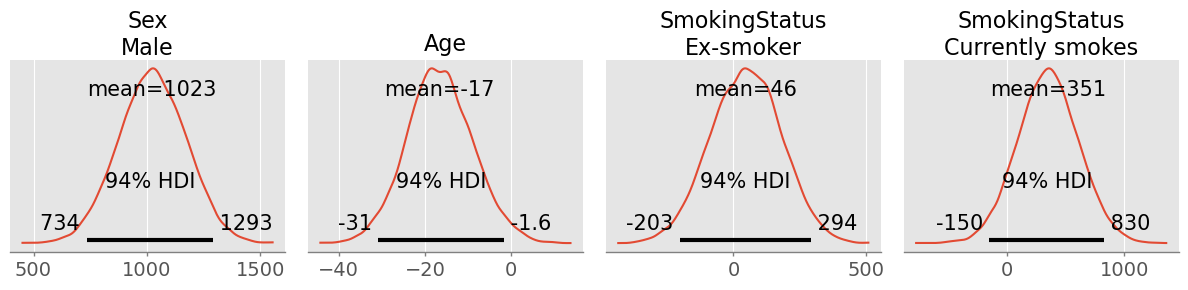

In [30]:
pm.plot_posterior( hierarchical_trace2, var_names=["Sex", "Age", "SmokingStatus"], figsize=(12,3) )
plt.tight_layout()

Interactions (Slopes):

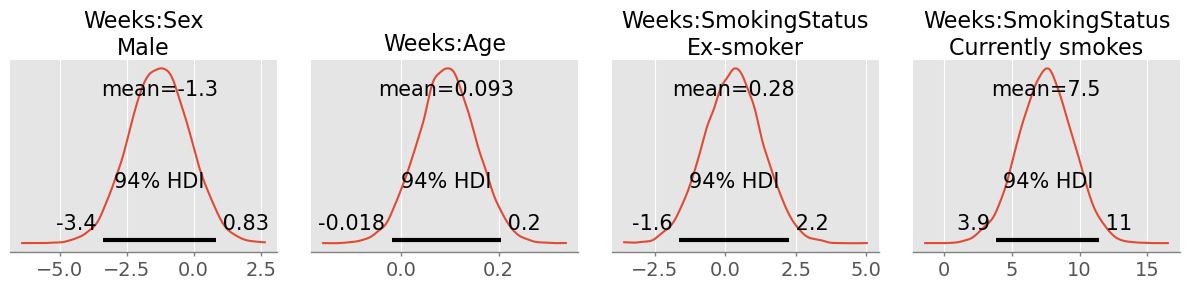

In [31]:
pm.plot_posterior( hierarchical_trace2, var_names="Weeks:", filter_vars="like", figsize=(12,3) )
plt.tight_layout()

It appears that smoking helps the disease! However it is probably rather a collider effect! (see lecture)